# Data preparation

In [0]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('insurance').getOrCreate()
df = spark.read.csv('/FileStore/tables/train.csv',inferSchema=True,header=True)
df.printSchema()

root
-- id: integer (nullable = true)
-- Gender: string (nullable = true)
-- Age: integer (nullable = true)
-- Driving_License: integer (nullable = true)
-- Region_Code: double (nullable = true)
-- Previously_Insured: integer (nullable = true)
-- Vehicle_Age: string (nullable = true)
-- Vehicle_Damage: string (nullable = true)
-- Annual_Premium: double (nullable = true)
-- Policy_Sales_Channel: double (nullable = true)
-- Vintage: integer (nullable = true)
-- Response: integer (nullable = true)

In [0]:
df.count()

Out[2]: 381109

###Correct schema of some variables

In [0]:
from pyspark.sql.types import StructField,StringType,IntegerType,DoubleType,StructType
df_schema = StructType([
    StructField('id', StringType(), True),
    StructField('Gender', StringType(), True),
    StructField('Age', IntegerType(), True),
    StructField('Driving_License', StringType(), True),
    StructField('Region_Code', StringType(), True),
    StructField('Previously_Insured', StringType(), True),
    StructField('Vehicle_Age', StringType(), True),
    StructField('Vehicle_Damage', StringType(), True),
    StructField('Annual_Premium', DoubleType(), True),
    StructField('Policy_Sales_Channel', StringType(), True),
    StructField('Vintage', IntegerType(), True),
    StructField('Response', StringType(), True)
    ])
df = spark.createDataFrame(df.collect(),schema = df_schema)
df.printSchema()

root
-- id: string (nullable = true)
-- Gender: string (nullable = true)
-- Age: integer (nullable = true)
-- Driving_License: string (nullable = true)
-- Region_Code: string (nullable = true)
-- Previously_Insured: string (nullable = true)
-- Vehicle_Age: string (nullable = true)
-- Vehicle_Damage: string (nullable = true)
-- Annual_Premium: double (nullable = true)
-- Policy_Sales_Channel: string (nullable = true)
-- Vintage: integer (nullable = true)
-- Response: string (nullable = true)

### As schema shows, each column might have null values, so we'll deal with missing value later

In [0]:
df.show()

+---+------+---+---------------+-----------+------------------+-----------+--------------+--------------+--------------------+-------+--------+
 id|Gender|Age|Driving_License|Region_Code|Previously_Insured|Vehicle_Age|Vehicle_Damage|Annual_Premium|Policy_Sales_Channel|Vintage|Response|
+---+------+---+---------------+-----------+------------------+-----------+--------------+--------------+--------------------+-------+--------+
 1| Male| 44| 1| 28.0| 0| > 2 Years| Yes| 40454.0| 26.0| 217| 1|
 2| Male| 76| 1| 3.0| 0| 1-2 Year| No| 33536.0| 26.0| 183| 0|
 3| Male| 47| 1| 28.0| 0| > 2 Years| Yes| 38294.0| 26.0| 27| 1|
 4| Male| 21| 1| 11.0| 1| < 1 Year| No| 28619.0| 152.0| 203| 0|
 5|Female| 29| 1| 41.0| 1| < 1 Year| No| 27496.0| 152.0| 39| 0|
 6|Female| 24| 1| 33.0| 0| < 1 Year| Yes| 2630.0| 160.0| 176| 0|
 7| Male| 23| 1| 11.0| 0| < 1 Year| Yes| 23367.0| 152.0| 249| 0|
 8|Female| 56| 1| 28.0| 0| 1-2 Year| Yes| 32031.0| 26.0| 72| 1|
 9|Female| 24| 1| 3.0| 1| < 1 Year| No| 27619.0| 152.0| 28| 0|
 10|Female| 32| 1| 6.0| 1| < 1 Year| No| 28771.0| 152.0| 80| 0|
 11|Female| 47| 1| 35.0| 0| 1-2 Year| Yes| 47576.0| 124.0| 46| 1|
 12|Female| 24| 1| 50.0| 1| < 1 Year| No| 48699.0| 152.0| 289| 0|
 13|Female| 41| 1| 15.0| 1| 1-2 Year| No| 31409.0| 14.0| 221| 0|
 14| Male| 76| 1| 28.0| 0| 1-2 Year| Yes| 36770.0| 13.0| 15| 0|
 15| Male| 71| 1| 28.0| 1| 1-2 Year| No| 46818.0| 30.0| 58| 0|
 16| Male| 37| 1| 6.0| 0| 1-2 Year| Yes| 2630.0| 156.0| 147| 1|
 17|Female| 25| 1| 45.0| 0| < 1 Year| Yes| 26218.0| 160.0| 256| 0|
 18|Female| 25| 1| 35.0| 1| < 1 Year| No| 46622.0| 152.0| 299| 0|
 19| Male| 42| 1| 28.0| 0| 1-2 Year| Yes| 33667.0| 124.0| 158| 0|
 20|Female| 60| 1| 33.0| 0| 1-2 Year| Yes| 32363.0| 124.0| 102| 1|
+---+------+---+---------------+-----------+------------------+-----------+--------------+--------------+--------------------+-------+--------+
only showing top 20 rows

# now let's check nulls for each column 
### For nulls(missing values), we can impute them by statistical values or drop it if it had too much

In [0]:
from pyspark.sql.functions import*
from pyspark.sql.functions import when,count,col
null_report=df.select([count(when(isnull(c), c)).alias(c) for c in df.columns])
print("Number of Rows: ",df.count(), "   Number of Columns: ",len(df.columns))
null_report.show()

Number of Rows: 381109 Number of Columns: 12
+---+------+---+---------------+-----------+------------------+-----------+--------------+--------------+--------------------+-------+--------+
 id|Gender|Age|Driving_License|Region_Code|Previously_Insured|Vehicle_Age|Vehicle_Damage|Annual_Premium|Policy_Sales_Channel|Vintage|Response|
+---+------+---+---------------+-----------+------------------+-----------+--------------+--------------+--------------------+-------+--------+
 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0|
+---+------+---+---------------+-----------+------------------+-----------+--------------+--------------+--------------------+-------+--------+

### Surprisingly, the data has no nulls, so we can do some descriptive analysis

In [0]:
df.show()

+---+------+---+---------------+-----------+------------------+-----------+--------------+--------------+--------------------+-------+--------+
 id|Gender|Age|Driving_License|Region_Code|Previously_Insured|Vehicle_Age|Vehicle_Damage|Annual_Premium|Policy_Sales_Channel|Vintage|Response|
+---+------+---+---------------+-----------+------------------+-----------+--------------+--------------+--------------------+-------+--------+
 1| Male| 44| 1| 28.0| 0| > 2 Years| Yes| 40454.0| 26.0| 217| 1|
 2| Male| 76| 1| 3.0| 0| 1-2 Year| No| 33536.0| 26.0| 183| 0|
 3| Male| 47| 1| 28.0| 0| > 2 Years| Yes| 38294.0| 26.0| 27| 1|
 4| Male| 21| 1| 11.0| 1| < 1 Year| No| 28619.0| 152.0| 203| 0|
 5|Female| 29| 1| 41.0| 1| < 1 Year| No| 27496.0| 152.0| 39| 0|
 6|Female| 24| 1| 33.0| 0| < 1 Year| Yes| 2630.0| 160.0| 176| 0|
 7| Male| 23| 1| 11.0| 0| < 1 Year| Yes| 23367.0| 152.0| 249| 0|
 8|Female| 56| 1| 28.0| 0| 1-2 Year| Yes| 32031.0| 26.0| 72| 1|
 9|Female| 24| 1| 3.0| 1| < 1 Year| No| 27619.0| 152.0| 28| 0|
 10|Female| 32| 1| 6.0| 1| < 1 Year| No| 28771.0| 152.0| 80| 0|
 11|Female| 47| 1| 35.0| 0| 1-2 Year| Yes| 47576.0| 124.0| 46| 1|
 12|Female| 24| 1| 50.0| 1| < 1 Year| No| 48699.0| 152.0| 289| 0|
 13|Female| 41| 1| 15.0| 1| 1-2 Year| No| 31409.0| 14.0| 221| 0|
 14| Male| 76| 1| 28.0| 0| 1-2 Year| Yes| 36770.0| 13.0| 15| 0|
 15| Male| 71| 1| 28.0| 1| 1-2 Year| No| 46818.0| 30.0| 58| 0|
 16| Male| 37| 1| 6.0| 0| 1-2 Year| Yes| 2630.0| 156.0| 147| 1|
 17|Female| 25| 1| 45.0| 0| < 1 Year| Yes| 26218.0| 160.0| 256| 0|
 18|Female| 25| 1| 35.0| 1| < 1 Year| No| 46622.0| 152.0| 299| 0|
 19| Male| 42| 1| 28.0| 0| 1-2 Year| Yes| 33667.0| 124.0| 158| 0|
 20|Female| 60| 1| 33.0| 0| 1-2 Year| Yes| 32363.0| 124.0| 102| 1|
+---+------+---+---------------+-----------+------------------+-----------+--------------+--------------+--------------------+-------+--------+
only showing top 20 rows

In [0]:
# Here numercal columns are picked for descriptive analysis 
df.select('Annual_Premium','Vintage','Age').describe().show()

+-------+------------------+------------------+------------------+
summary| Annual_Premium| Vintage| Age|
+-------+------------------+------------------+------------------+
 count| 381109| 381109| 381109|
 mean|30564.389581458323|154.34739667654136|38.822583565331705|
 stddev|17213.155056980144| 83.67130362658735|15.511611018095339|
 min| 2630.0| 10| 20|
 max| 540165.0| 299| 85|
+-------+------------------+------------------+------------------+

### From the descriptive statistic, there is no issue. Now, let remove outliers.

In [0]:
import matplotlib.pyplot as plt 
import pandas as pd
import random as rnd 

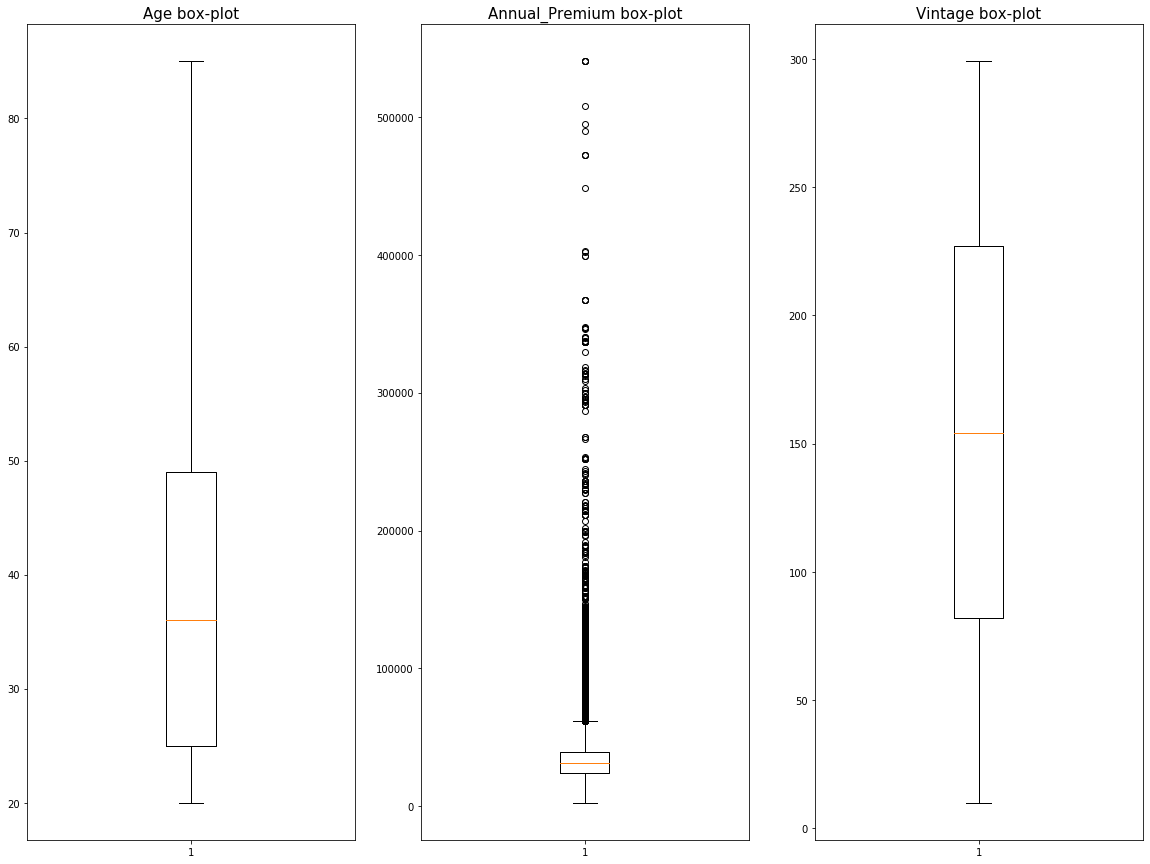

In [0]:
df1=df.toPandas()
f,(ax1, ax2, ax3) = plt.subplots(1,3, sharey=False,figsize=(20,15)) 
ax1.boxplot(df1['Age'])
ax1.set_title("Age box-plot", fontsize=15)
ax2.boxplot(df1['Annual_Premium'])
ax2.set_title("Annual_Premium box-plot", fontsize=15)
ax3.boxplot(df1['Vintage'])
ax3.set_title("Vintage box-plot", fontsize=15)

### According to the box-plots, there are some outliers in 'Annual_Premium'

### Next, we use the interquantile rule to delete outliers.

In [0]:
quantiles = {
    c: dict(
        zip(["q1", "q3"], df.approxQuantile(c, [0.25, 0.75], 0))
    )
    for c in ["Age", "Annual_Premium","Vintage"]
}
quantiles

Out[10]: {'Age': {'q1': 25.0, 'q3': 49.0},
 'Annual_Premium': {'q1': 24405.0, 'q3': 39400.0},
 'Vintage': {'q1': 82.0, 'q3': 227.0}}

In [0]:
for i in quantiles:
    iqr = quantiles[i]['q3'] - quantiles[i]['q1']
    quantiles[i]['lower_bound'] = quantiles[i]['q1'] - (iqr * 1.5)
    quantiles[i]['upper_bound'] = quantiles[i]['q3'] + (iqr * 1.5)
print(quantiles)

{'Age': {'q1': 25.0, 'q3': 49.0, 'lower_bound': -11.0, 'upper_bound': 85.0}, 'Annual_Premium': {'q1': 24405.0, 'q3': 39400.0, 'lower_bound': 1912.5, 'upper_bound': 61892.5}, 'Vintage': {'q1': 82.0, 'q3': 227.0, 'lower_bound': -135.5, 'upper_bound': 444.5}}

In [0]:
import pyspark.sql.functions as f
df_clean=df.select(
    "*",
    *[
        f.when(
            f.col(c).between(quantiles[c]['lower_bound'], quantiles[c]['upper_bound']),
            0
        ).otherwise(1).alias(c+"_out") 
        for c in ["Age", "Annual_Premium","Vintage"]
    ]
)
df_clean.show(10)

+---+------+---+---------------+-----------+------------------+-----------+--------------+--------------+--------------------+-------+--------+-------+------------------+-----------+
 id|Gender|Age|Driving_License|Region_Code|Previously_Insured|Vehicle_Age|Vehicle_Damage|Annual_Premium|Policy_Sales_Channel|Vintage|Response|Age_out|Annual_Premium_out|Vintage_out|
+---+------+---+---------------+-----------+------------------+-----------+--------------+--------------+--------------------+-------+--------+-------+------------------+-----------+
 1| Male| 44| 1| 28.0| 0| > 2 Years| Yes| 40454.0| 26.0| 217| 1| 0| 0| 0|
 2| Male| 76| 1| 3.0| 0| 1-2 Year| No| 33536.0| 26.0| 183| 0| 0| 0| 0|
 3| Male| 47| 1| 28.0| 0| > 2 Years| Yes| 38294.0| 26.0| 27| 1| 0| 0| 0|
 4| Male| 21| 1| 11.0| 1| < 1 Year| No| 28619.0| 152.0| 203| 0| 0| 0| 0|
 5|Female| 29| 1| 41.0| 1| < 1 Year| No| 27496.0| 152.0| 39| 0| 0| 0| 0|
 6|Female| 24| 1| 33.0| 0| < 1 Year| Yes| 2630.0| 160.0| 176| 0| 0| 0| 0|
 7| Male| 23| 1| 11.0| 0| < 1 Year| Yes| 23367.0| 152.0| 249| 0| 0| 0| 0|
 8|Female| 56| 1| 28.0| 0| 1-2 Year| Yes| 32031.0| 26.0| 72| 1| 0| 0| 0|
 9|Female| 24| 1| 3.0| 1| < 1 Year| No| 27619.0| 152.0| 28| 0| 0| 0| 0|
 10|Female| 32| 1| 6.0| 1| < 1 Year| No| 28771.0| 152.0| 80| 0| 0| 0| 0|
+---+------+---+---------------+-----------+------------------+-----------+--------------+--------------+--------------------+-------+--------+-------+------------------+-----------+
only showing top 10 rows

In [0]:
from pyspark.sql.functions import col
df_clean=df_clean.withColumn("outliers", col("Age_out")+col("Annual_Premium_out")+col("Vintage_out"))
df_clean.show()

+---+------+---+---------------+-----------+------------------+-----------+--------------+--------------+--------------------+-------+--------+-------+------------------+-----------+--------+
 id|Gender|Age|Driving_License|Region_Code|Previously_Insured|Vehicle_Age|Vehicle_Damage|Annual_Premium|Policy_Sales_Channel|Vintage|Response|Age_out|Annual_Premium_out|Vintage_out|outliers|
+---+------+---+---------------+-----------+------------------+-----------+--------------+--------------+--------------------+-------+--------+-------+------------------+-----------+--------+
 1| Male| 44| 1| 28.0| 0| > 2 Years| Yes| 40454.0| 26.0| 217| 1| 0| 0| 0| 0|
 2| Male| 76| 1| 3.0| 0| 1-2 Year| No| 33536.0| 26.0| 183| 0| 0| 0| 0| 0|
 3| Male| 47| 1| 28.0| 0| > 2 Years| Yes| 38294.0| 26.0| 27| 1| 0| 0| 0| 0|
 4| Male| 21| 1| 11.0| 1| < 1 Year| No| 28619.0| 152.0| 203| 0| 0| 0| 0| 0|
 5|Female| 29| 1| 41.0| 1| < 1 Year| No| 27496.0| 152.0| 39| 0| 0| 0| 0| 0|
 6|Female| 24| 1| 33.0| 0| < 1 Year| Yes| 2630.0| 160.0| 176| 0| 0| 0| 0| 0|
 7| Male| 23| 1| 11.0| 0| < 1 Year| Yes| 23367.0| 152.0| 249| 0| 0| 0| 0| 0|
 8|Female| 56| 1| 28.0| 0| 1-2 Year| Yes| 32031.0| 26.0| 72| 1| 0| 0| 0| 0|
 9|Female| 24| 1| 3.0| 1| < 1 Year| No| 27619.0| 152.0| 28| 0| 0| 0| 0| 0|
 10|Female| 32| 1| 6.0| 1| < 1 Year| No| 28771.0| 152.0| 80| 0| 0| 0| 0| 0|
 11|Female| 47| 1| 35.0| 0| 1-2 Year| Yes| 47576.0| 124.0| 46| 1| 0| 0| 0| 0|
 12|Female| 24| 1| 50.0| 1| < 1 Year| No| 48699.0| 152.0| 289| 0| 0| 0| 0| 0|
 13|Female| 41| 1| 15.0| 1| 1-2 Year| No| 31409.0| 14.0| 221| 0| 0| 0| 0| 0|
 14| Male| 76| 1| 28.0| 0| 1-2 Year| Yes| 36770.0| 13.0| 15| 0| 0| 0| 0| 0|
 15| Male| 71| 1| 28.0| 1| 1-2 Year| No| 46818.0| 30.0| 58| 0| 0| 0| 0| 0|
 16| Male| 37| 1| 6.0| 0| 1-2 Year| Yes| 2630.0| 156.0| 147| 1| 0| 0| 0| 0|
 17|Female| 25| 1| 45.0| 0| < 1 Year| Yes| 26218.0| 160.0| 256| 0| 0| 0| 0| 0|
 18|Female| 25| 1| 35.0| 1| < 1 Year| No| 46622.0| 152.0| 299| 0| 0| 0| 0| 0|
 19| Male| 42| 1| 28.0| 0| 1-2 Year| Yes| 33667.0| 124.0| 158| 0| 0| 0| 0| 0|
 20|Female| 60| 1| 33.0| 0| 1-2 Year| Yes| 32363.0| 124.0| 102| 1| 0| 0| 0| 0|
+---+------+---+---------------+-----------+------------------+-----------+--------------+--------------+--------------------+-------+--------+-------+------------------+-----------+--------+
only showing top 20 rows

In [0]:
#removing outliers to make a better dataset
df_clean = df_clean.filter((df_clean.outliers==0))
df_new = df_clean.select(['id','Gender','Age','Driving_License','Region_Code','Previously_Insured','Vehicle_Age','Vehicle_Damage','Annual_Premium','Policy_Sales_Channel','Vintage','Response'])
df_new.select('Age','Annual_Premium','Vintage').describe().show()

+-------+------------------+------------------+------------------+
summary| Age| Annual_Premium| Vintage|
+-------+------------------+------------------+------------------+
 count| 370789| 370789| 370789|
 mean| 38.67034351072982|29264.643972717637|154.34544174719315|
 stddev|15.440166283175778|14743.056656364859| 83.67047843171547|
 min| 20| 2630.0| 10|
 max| 85| 61892.0| 299|
+-------+------------------+------------------+------------------+

###Let check how many percentage of data we have left.

In [0]:
df_new.count()/df.count()*100

Out[15]: 97.29211327992779

### After deleting outliers, we still have about 97% of the data left. Therefore, it is enough to use in the next steps.

# Data visualization

In [0]:
import matplotlib.pyplot as plt 
import pandas as pd
import random as rnd 
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark import SparkContext

In [0]:
df_rs=df_new.select('Response').toPandas()
df_rs.shape

Out[17]: (370789, 1)

###  Response (Target variable)

In [0]:
# Create function for pie-chart
def draw_pie_chart(data, column, fig, renamed_index_dict, title):
    default_colors = ['#66b3ff', '#ff9999', '#99ff99', '#ffcc99', '#c2c2f0', '#ffb3e6', '#ff6666']
    rnd.shuffle(default_colors)
    ax = data[column].value_counts().rename(index = renamed_index_dict).plot.pie(colors = default_colors, autopct='%1.1f%%', startangle=180, title = title)
    ax.set_ylabel('')  
    
#66b3ff = blue
#ff9999 = light red
#99ff99 = green
#ffcc99 = orange
#c2c2f0 = purple
#ffb3e6 = pink
#ff6666 = red

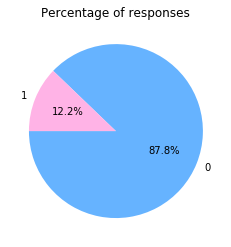

In [0]:
fig = plt.gcf()
draw_pie_chart(df_rs, 'Response', fig, {0: '0', 1: '1'}, 'Percentage of responses')

#### The data is unbalanced. Therefore, we have to resampling before building a prediction model.

In [0]:
df_pd=df_new.toPandas()
df_rs_no = df_pd[df_pd.Response == '0']
df_rs_yes = df_pd[df_pd.Response == '1']

#### Gender , Driving_License , Previously_Insured , Vehicle_Age , and Vehicle_Damage

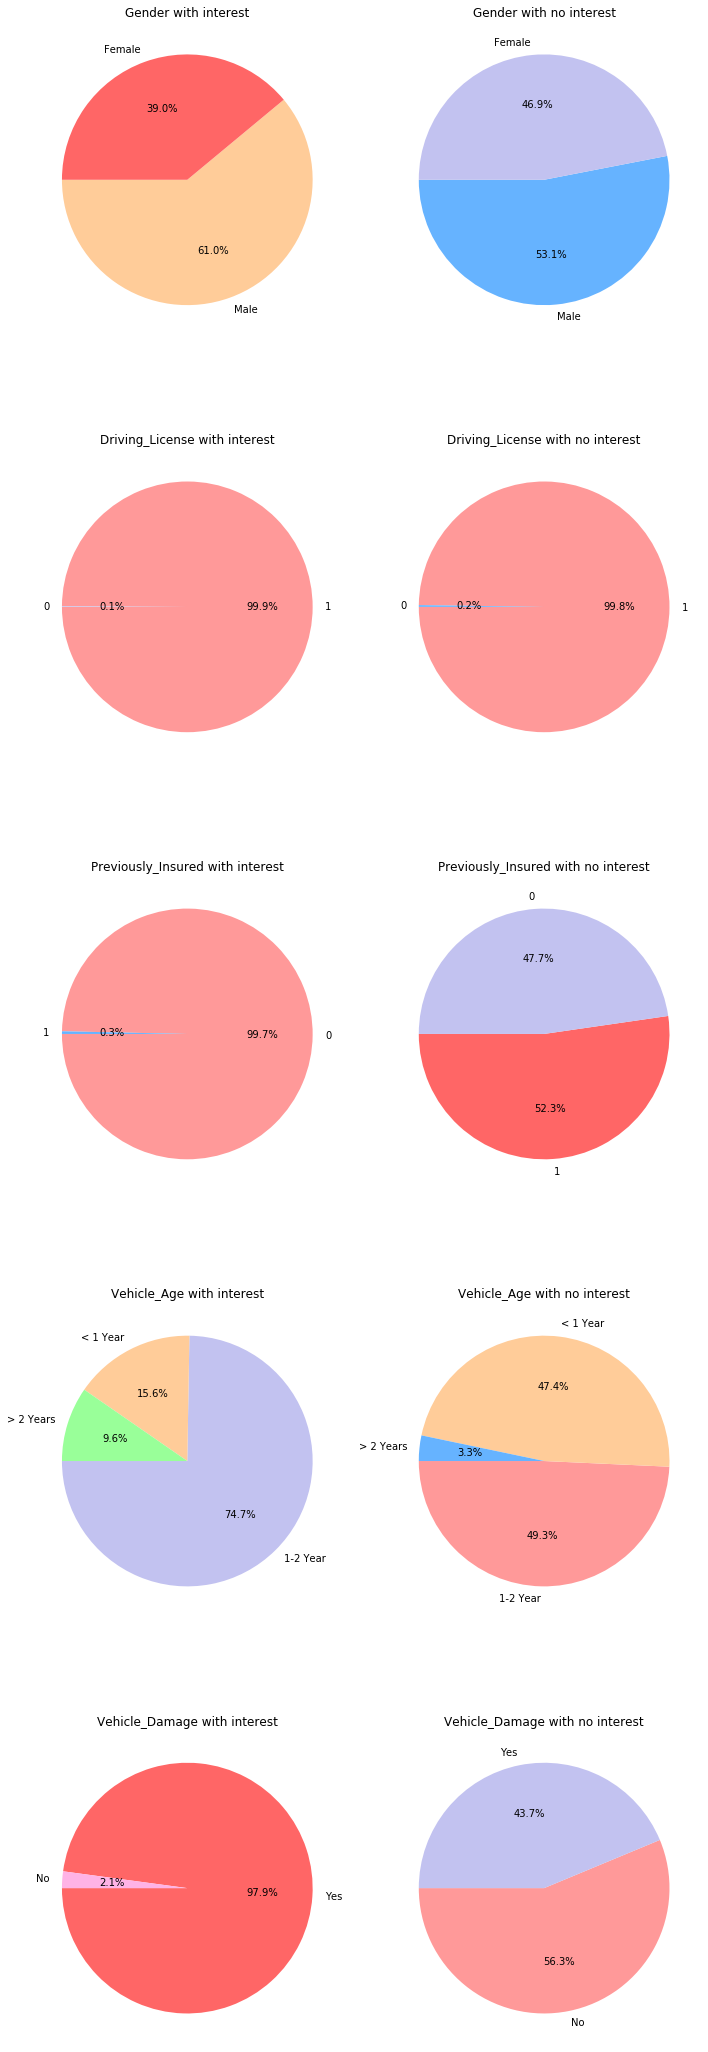

In [0]:
fig = plt.gcf()
fig.set_size_inches(10, 30)
grid_rows = 5
grid_cols = 2

# Draw Gender Pie chart
plt.subplot(grid_rows, grid_cols, 1)
draw_pie_chart(df_rs_yes, 'Gender', fig, {0: 'Female', 1: 'Male'}, 'Gender with interest')

plt.subplot(grid_rows, grid_cols, 2)
draw_pie_chart(df_rs_no , 'Gender', fig, {0: 'Female', 1: 'Male'}, 'Gender with no interest')

# Draw Driving_License chart
plt.subplot(grid_rows, grid_cols, 3)
draw_pie_chart(df_rs_yes, 'Driving_License', fig, {0:'0', 1:'1'}, 'Driving_License with interest')

plt.subplot(grid_rows, grid_cols, 4)
draw_pie_chart(df_rs_no, 'Driving_License', fig, {0:'0', 1:'1'}, 'Driving_License with no interest')

# Draw Previously_Insured chart
plt.subplot(grid_rows, grid_cols, 5)
draw_pie_chart(df_rs_yes, 'Previously_Insured', fig, {0:'0', 1:'1'}, 'Previously_Insured with interest')

plt.subplot(grid_rows, grid_cols, 6)
draw_pie_chart(df_rs_no , 'Previously_Insured', fig, {0:'0', 1:'1'}, 'Previously_Insured with no interest')

# Draw Vehicle_Age status chart
plt.subplot(grid_rows, grid_cols, 7)
draw_pie_chart(df_rs_yes, 'Vehicle_Age', fig, {0:'< 1 Year', 1:'1-2 Year',2:'> 2 Years'}, 'Vehicle_Age with interest')

plt.subplot(grid_rows, grid_cols, 8)
draw_pie_chart(df_rs_no , 'Vehicle_Age', fig, {0:'< 1 Year', 1:'1-2 Year',2:'> 2 Years'}, 'Vehicle_Age with no interest')

# Draw Vehicle_Damage type chart
plt.subplot(grid_rows, grid_cols, 9)
draw_pie_chart(df_rs_yes, 'Vehicle_Damage', fig, {0:'Yes', 1:'No'}, 'Vehicle_Damage with interest')

plt.subplot(grid_rows, grid_cols, 10)
draw_pie_chart(df_rs_no , 'Vehicle_Damage', fig, {0:'Yes', 1:'No'}, 'Vehicle_Damage with no interest')


fig.tight_layout()
plt.show()

###  Age , Annual_Premium , and Vintage

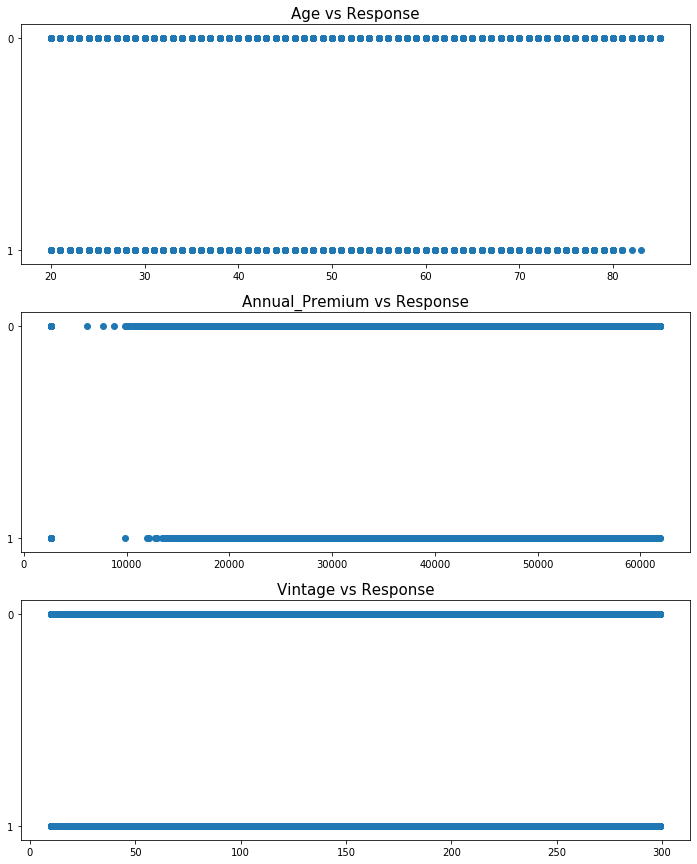

In [0]:
f,(ax1, ax2, ax3) = plt.subplots(3,1, sharey=True,figsize=(12,15)) 
ax1.scatter(df_pd['Age'],df_pd['Response'])
ax1.set_title("Age vs Response", fontsize=15)
ax2.scatter(df_pd['Annual_Premium'],df_pd['Response'])
ax2.set_title("Annual_Premium vs Response", fontsize=15)
ax3.scatter(df_pd['Vintage'],df_pd['Response'])
ax3.set_title("Vintage vs Response", fontsize=15)

In [0]:
# Conlusion so far: data itself is perfect, but its a good try for us to observe the data